# Розв'язання прямої та оберненої задач дифузії з використанням Python 3.7 та Jupyter Notebook
Залежність коефіцієнта дифузії для даної задачі наступна:
$$D(c) = 1\cdot 10^{-15}  $$

Будемо розв'язувати рівняння дифузії речовини згідно другого закону Фіка (одновимірний випадок): 

$$\frac{\partial c}{\partial t} = \frac{\partial}{\partial x}\bigg(D(c)\cdot\frac{\partial c}{\partial x}\bigg)$$

<IPython.core.display.Javascript object>


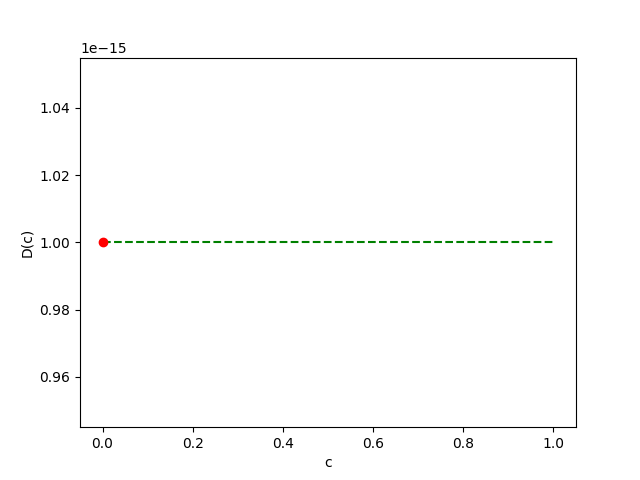

In [1]:
%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt


# constants
NPOINTS = 1000


###########################

def vectorize(func):
    """
    Vectorize decorator for python functions
    """
    def wrapper(vector):
        fn = np.vectorize(func)
        return fn(vector)
    return wrapper

@vectorize
def Dc(c: float)->float:
    return 1e-15 # + 6e-15*c


def plot_dc():
    c = np.linspace(0,1, NPOINTS)
    D = Dc(c)
    max_D_index = np.argmax(D) # Find the diffusion coefficient maxima index
    fig = plt.figure('Залежність коефіцієнта дифузії від концентрації')
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    ax.clear()
    ax.set_ylabel('D(c)')
    ax.set_xlabel('c')
    ax.plot(c,D,'g--', c[max_D_index], D[max_D_index], 'ro') # show on plot D(c) and maxima of D(c)
    fig.canvas.draw()
plot_dc()

<IPython.core.display.Javascript object>


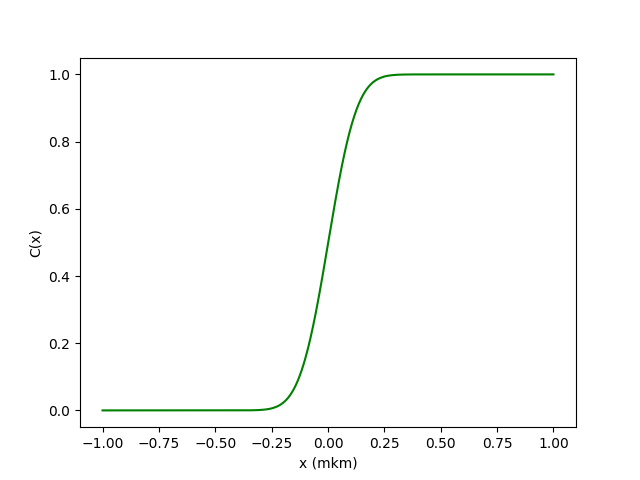


    Diffusion area distance: 2e-06 m 

    delta x: 1.9999999999999385e-09 

    delta t: 0.00039999999999997535 

    time: 5 s 

    
Solution completed


In [2]:
# constants for Diffusion PDE
LEFT_BOUND = -1e-6
RIGHT_BOUND = 1e-6



@vectorize
def initial_c(x):
    if x>0:
        return 1
    else:
        return 0
    
def get_max_D():
    c = np.linspace(0,1, NPOINTS)
    D = Dc(c)
    return np.max(D)

def solve_direct(TMAX: float):
    
    x = np.linspace(LEFT_BOUND,RIGHT_BOUND, NPOINTS+1) # set x vector

    DX2 = (x[1]-x[0])**2 # set dx2
    DX = x[1]-x[0]
    # calculate dt
    DT = (0.1*(DX**2))/get_max_D()
  
    
    koef = DT/DX2
    t = 0

    # initial condition
    c = np.array(initial_c(x), dtype=np.float64) 
  
    c_new = c.copy()
    curr_c, next_c = c, c
    
    fig = plt.figure('Профіль концентрації')
    ax = fig.add_subplot(111)
    fig.show()
    
    # solution  of equation
    while t < TMAX:
        
        D = Dc(c)    
        c_new[1:-1] = c[1:-1] + 0.5*koef*((D[2:]+D[1:-1])*(c[2:]-c[1:-1]) - (D[0:-2]+D[1:-1])*(c[1:-1]-c[0:-2]))
        
        c_new[0] = 0
        c_new[NPOINTS] = 1
        curr_c = c.copy()
        next_c = c_new.copy()
        
        c = c_new.copy()
        
        t+=DT
        if (t//DT) % 100 == 0:
            ax.clear()
            ax.set_ylabel('С(x)')
            ax.set_xlabel('x (mkm)')
            ax.plot(x/1e-6,c,'g-') 
            fig.canvas.draw()
        
    print(f"""
    Diffusion area distance: {RIGHT_BOUND-LEFT_BOUND} m \n
    delta x: {DX} \n
    delta t: {DT} \n
    time: {TMAX} s \n
    """)
    
    return DT, x, next_c, curr_c

dt, x, c, prev_c = solve_direct(5) # 5 seconds
print('Solution completed')
   


## Спотворення розв'язку прямої задачі дифузії для моделювання отримання експериметального профілю

<IPython.core.display.Javascript object>


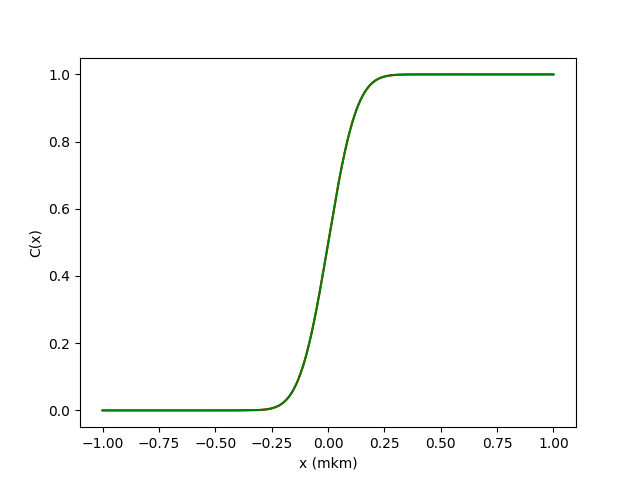

In [3]:
%matplotlib notebook
from numpy import random as rnd

An = 0.001 # 0.001 percent noise

def noise_concentration_profiles(c, prev_c, An):
    rnd.seed()
    noise = np.random.normal(0,An,NPOINTS+1) # (1 + An * (2*rnd.random(NPOINTS+1) - 1))
    return c+noise , prev_c+noise

cn, cnprev = noise_concentration_profiles(c, prev_c, An*0.01)
        
fig = plt.figure('Cпотворений профіль концентрації ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('С(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x/1e-6,cn,'r-',x/1e-6, cnprev, 'g-') 
fig.canvas.draw()

## Розв'язання оберненої задачі дифузії методом найменших квадратів з використанням лінійного наближення коефіцієнта дифузії
Маємо рівняння:
$$
\begin{equation*}
\frac{\partial c}{\partial t} = \frac{\partial }{\partial x}\bigg(D(c)\frac{\partial c }{\partial x}\bigg) \tag{1}
\end{equation*}
$$

Розпишемо похідні:
$$\frac{\partial c}{\partial t} = \frac{\partial D}{\partial c}\bigg(\frac{\partial c }{\partial x}\bigg)^{2}+ D(c)\frac{\partial^{2} c}{\partial x^{2}} \tag{2}$$

Замінимо коефіцієнт дифузії його лінійною апроксимацією:

$$
 \tilde D(c) = ac + b \tag{3}
$$
Похідна від коефіцієнта дифузії: 
$$
\frac{\partial \tilde D(c)}{\partial c} = \frac{\partial (ac + b)}{\partial c} = a  \tag{4}
$$
З врахуванням лінійної апроксимації наближення рівняння дифузії (2) матиме вигляд:
$$\frac{\partial c}{\partial t} = a\bigg(\frac{\partial c }{\partial x}\bigg)^{2}+ (ac + b)\frac{\partial^{2} c}{\partial x^{2}} \tag{5}$$
Розглядатимемо наше рівняння на дискретному просторі, тоді введемо позначення для похідних в $i$-му вузлі: $\frac{\partial c}{\partial t}$ => $c_{t}^{i}$, $\frac{\partial c }{\partial x}$ => $c_{x}^{i}$, $\frac{\partial^{2} c}{\partial x^{2}}$ => $c_{xx}^{i}$
В цих змінних наше рівняння в $i$-му вузлі має вигляд:
$$c_{t}^{i}  = ac_{x}^{i} + (ac^{i}+b) c_{xx}^{i} \tag{6}$$

Введемо мінімізуючий функціонал виду:
$$E[a,b] =  \sum_{i=1}^{N}\bigg[c_{t}^{i} - ac_{x}^{i} - (ac^{i}+b) c_{xx}^{i} \bigg]^{2}  \tag{7}$$


Візьмемо частинні похідні від функціоналу по змінних $a$ та $b$:
$$
\frac{\partial E[a,b]}{\partial a} = -2\sum_{i=1}^{N}\bigg[c_{t}^{i} - ac_{x}^{i} - (ac^{i}+b) c_{xx}^{i} \bigg](c_{x}^{i}+c^{i}c_{xx}^{i}) \tag{8}
$$
$$
\frac{\partial E[a,b]}{\partial b} = -2\sum_{i=1}^{N}\bigg[c_{t}^{i} - ac_{x}^{i} - (ac^{i}+b) c_{xx}^{i} \bigg]c_{xx}^{i} \tag{9}
$$

$$
\sum_{i=1}^{N}c_{t}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) - a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})^{2}-b\sum_{i=1}^{N}c_{xx}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) = 0 \tag{10}
$$
$$
\sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i} - a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}-b\sum_{i=1}^{N}(c_{xx}^{i})^{2}= 0 \tag{11}
$$

$$
 a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})^{2} + b\sum_{i=1}^{N}c_{xx}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) = \sum_{i=1}^{N}c_{t}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) \tag{12}
$$
$$
 a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}+b\sum_{i=1}^{N}(c_{xx}^{i})^{2}= \sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i}  \tag{13}
$$

$$
 b = \frac{\sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i} - a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} = \frac{\sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} -a\frac{\sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} \tag{14}
$$

$$
 a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})^{2} + \bigg[\frac{\sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} -a\frac{\sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}}\bigg]\sum_{i=1}^{N}c_{xx}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) = \sum_{i=1}^{N}c_{t}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) \tag{15}
$$

$$
 a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})^{2} + \frac{\sum_{i=1}^{N}c_{xx}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i})\sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} -a\frac{\big(\sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}\big)^{2}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} = \sum_{i=1}^{N}c_{t}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) \tag{16}
$$

$$
 a \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})^{2} + \frac{\sum_{i=1}^{N}c_{xx}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i})\sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} -a\frac{\big(\sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}\big)^{2}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}} = \sum_{i=1}^{N}c_{t}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i}) \tag{17}
$$

$$
 a =\frac{ \sum_{i=1}^{N}c_{t}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i})-\frac{\sum_{i=1}^{N}c_{xx}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i})\sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}}}{ \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})^{2} -\frac{\big(\sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}\big)^{2}}{\sum_{i=1}^{N}(c_{xx}^{i})^{2}}} \tag{18}
$$

Введемо позначення сум:
$$
p = \sum_{i=1}^{N}c_{t}^{i}(c_{x}^{i} + c^{i}c_{xx}^{i})
$$
$$
r = \sum_{i=1}^{N}(c_{xx}^{i})^{2}
$$

$$
q = \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})^{2}
$$
$$
v = \sum_{i=1}^{N}(c_{x}^{i} + c^{i}c_{xx}^{i})c_{xx}^{i}
$$
$$
w = \sum_{i=1}^{N}c_{t}^{i}c_{xx}^{i}
$$

Тоді вираз для $a$ (18) набуде вигляду:
$$
a = \frac{p - \frac{vw}{r}}{q - \frac{v^{2}}{r}}
$$

Вираз для $b$ (14) матиме вигляд в цих змінних:
$$
b = \frac{w - av}{r}
$$

**Розрахуємо похідні спотвореного розв'язку прямої задачі дифузії.**

<IPython.core.display.Javascript object>


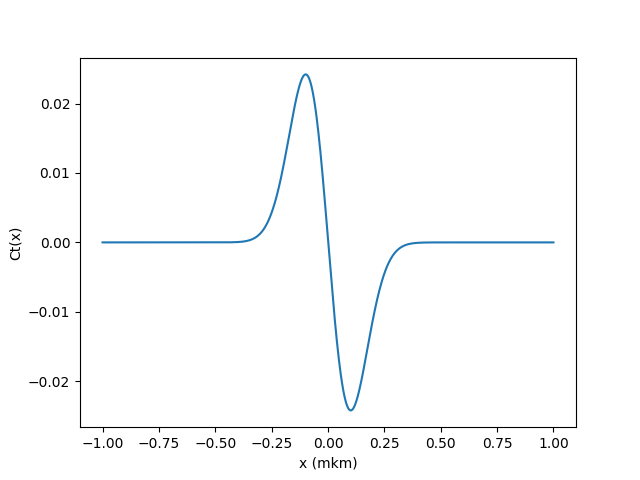

In [4]:
ct = (cn - cnprev) / dt

# plot derivative Ct
%matplotlib notebook
fig = plt.figure('Профіль першої похідної від концентрації по часу ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Сt(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x / 1e-6,ct) 
fig.canvas.draw()

<IPython.core.display.Javascript object>


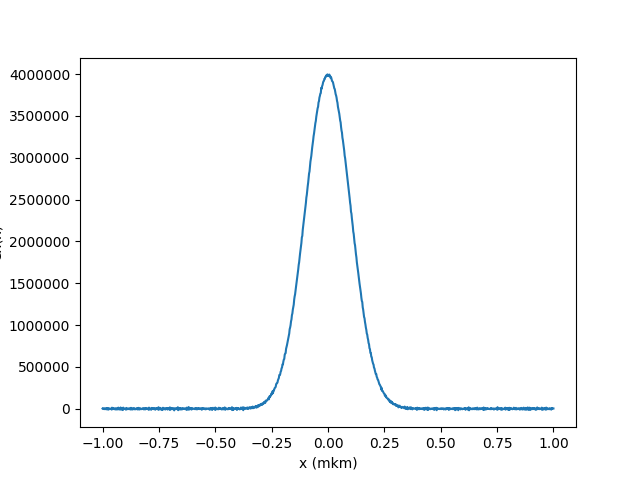

In [5]:
cx = np.zeros(NPOINTS+1, dtype=np.float64)
cx[0:-1] = (cn[1:] - cn[0:-1])/(x[1] - x[0])
cx[NPOINTS] = cx[NPOINTS-1]

# plot derivative Cx
%matplotlib notebook
fig = plt.figure('Профіль першої похідної від концентрації по координаті ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Сx(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x / 1e-6,cx) 
fig.canvas.draw()


<IPython.core.display.Javascript object>


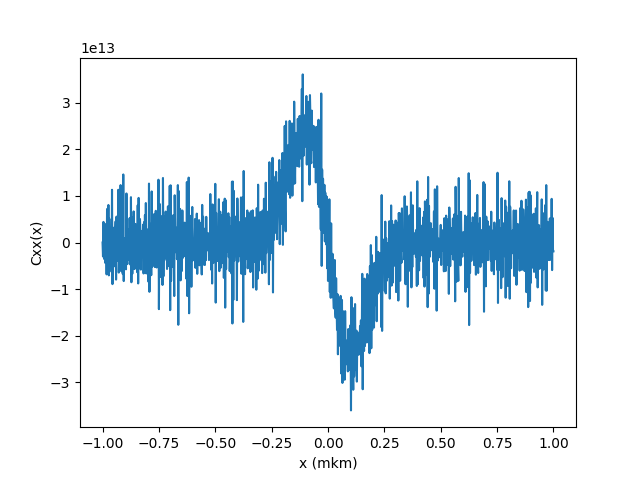

In [6]:
cxx = np.zeros(NPOINTS+1,dtype=np.float64)
cxx[1:-1] = (cn[0:-2] - 2.0*cn[1:-1] + cn[2:])/((x[1] - x[0])**2)
cxx[0] = cx[1]
cxx[NPOINTS] = cxx[NPOINTS-1]

# plot derivative Cxx
%matplotlib notebook
fig = plt.figure('Профіль другої похідної від концентрації по координаті ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Сxx(x)')
ax.set_xlabel('x (mkm)')
ax.plot(x / 1e-6,cxx) 
fig.canvas.draw()

<IPython.core.display.Javascript object>


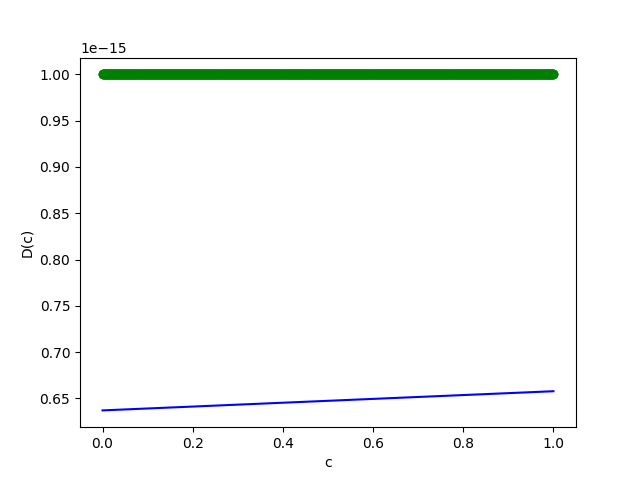

a=2.070813863791063e-17
b=6.371047412221143e-16


In [9]:
# calculate sums
p = np.sum(ct*(cx + cn*cxx))
r = np.sum(cxx**2)
q = np.sum((cx + cn*cxx)**2)
v = np.sum((cx + cn*cxx)*cxx)
w = np.sum(ct*cxx)

# calculate coefficient a and b for D(c) = ac+b
a = (p - (v*w)/r)/(q - (v**2)/r)
b = (w - a*v)/r

c_ax = np.linspace(0,1, NPOINTS)
D_aproxim = ( a* c_ax) + b
D_real = Dc(c_ax)

# plot aproxim
%matplotlib notebook
fig = plt.figure('Теоретична та відновлена з оберненої задачі залежність коефіцієнта дифузії ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('D(c)')
ax.set_xlabel('c')
ax.plot(c_ax,np.round(D_real,20), 'go-', c_ax, np.round(D_aproxim,20), 'b-') 

#ax.plot( c_ax, np.round(D_aproxim, 17), 'b-') 
fig.canvas.draw()
print(f"a={a}")
print(f"b={b}")

Синім позначено залежність коефіцієнта дифузії отриманого з оберненої задачі,  зеленим - теоретично заданий коефіцієнт дифузії